In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.contrib.layers as layers

In [2]:
from sklearn.datasets import make_moons
from matplotlib import pyplot as plt
from flows import NVPFlow, FlowSequence, ResFlow, BNFlow, phase, floatX

In [3]:
inp = tf.placeholder(floatX, [None, 2])

In [4]:
flow = NVPFlow(2, 'init_flow')(inp)

for i in range(0, 15):
    flow = NVPFlow(name='res_' + str(i))(flow)
    if i % 2 == 0:
        flow = BNFlow(name='bn_' + str(i))(flow)

In [5]:
flow[-1].output /= 4

In [6]:
flow[-1].logj.shape

TensorShape([])

In [7]:
flows = flow

In [8]:
logj = flows.calc_logj()

In [9]:
logj

<tf.Tensor 'add_23:0' shape=(?,) dtype=float64>

In [10]:
mm = np.zeros(2, np.int)
for fl in flows:
    if hasattr(fl, 'mask'):
        mm += fl.mask
        print(fl.mask)

[ True False]
[False  True]
[ True False]
[False  True]
[ True False]
[False  True]
[ True False]
[False  True]
[False  True]
[ True False]
[ True False]
[ True False]
[False  True]
[False  True]
[ True False]
[False  True]


In [11]:
mm

array([8, 8])

In [12]:
with tf.name_scope('gain_scope'):
    z = flows[-1].output
    gain = tf.reduce_sum(-(z*z)/2, axis=-1) + logj
    gain = tf.reduce_mean(gain)

In [13]:
z

<tf.Tensor 'truediv:0' shape=(?, 2) dtype=float64>

In [14]:
train_op = tf.train.AdamOptimizer(0.00003).minimize(-gain)
train_op = [train_op] + flows.ops

In [15]:
X, _ = make_moons(n_samples=1024, noise=0.13)

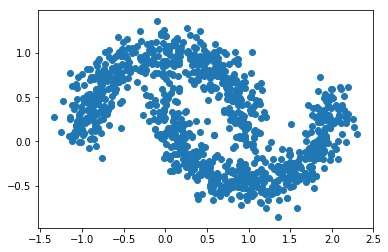

In [16]:
plt.scatter(X[:,0], X[:,1])
plt.show()

In [17]:
sess = tf.InteractiveSession()

In [18]:
tf.global_variables_initializer().run()

In [19]:
logj.eval({inp:X, phase: False}).mean()

-5.875158852779937

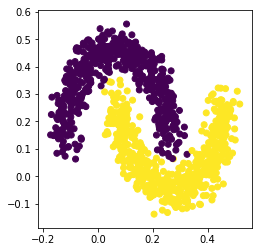

In [20]:
X, y = make_moons(n_samples=1024, noise=0.13)
ver = z.eval({inp:X})

ax = plt.gca()
ax.set_aspect('equal')
plt.scatter(ver[:,0], ver[:,1], c=y)
plt.show()

In [21]:
writer = tf.summary.FileWriter('/tmp/tfdbg')

In [22]:
writer.add_graph(tf.get_default_graph())

In [ ]:
for _ in range(80):
    for _ in range(1000):
        X, _ = make_moons(n_samples=256, noise=0.13)
        sess.run(train_op, {inp:X})
    print(gain.eval({inp:X, phase: False}).mean())

-0.5736962588495675
-0.513105181586895
-0.47371249503724355
-0.434301290085443
-0.3955375069786833
-0.3580231979326864
-0.31817069238270174
-0.2777628594362439
-0.24504112665876335
-0.20864734090322043
-0.17475819196389392
-0.1375580670338098
-0.10493865223860671
-0.07099023633599633


In [25]:
inverse = flows.apply(inp*4, inverse=True)

In [34]:
restored = inverse.eval({inp:np.random.normal(size=[400,2]), phase: False})
#restored = inverse.eval({inp:ver})

In [35]:
restored = restored[np.logical_not(np.any(restored**2 > 30, axis=-1))]

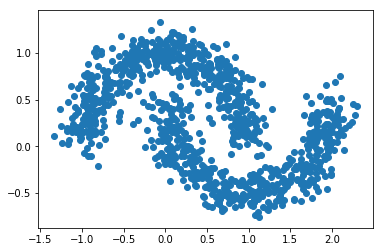

In [36]:
plt.scatter(restored[:,0], restored[:,1])
plt.show()

In [32]:
flows.ops

[]